## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [204]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [205]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [206]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [207]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [208]:
sum(df.converted) / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [209]:
# Create a mask to filter the dataset.
mask = ((df.group == 'treatment') & (df.landing_page != 'new_page')) | ((df.group == 'control') & (df.landing_page == 'new_page'))
df[mask].shape[0]

3893

f. Do any of the rows have missing values?

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [211]:
# Use the mask to filter out the rows to drop
df2 = df.drop(df[mask].index, axis=0)

In [212]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [213]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [214]:
# Store the user_id in varibale to use later
dup = df2[df2.user_id.duplicated() == True]['user_id'].loc[2893]
dup

773192

c. What is the row information for the repeat **user_id**? 

In [215]:
df2[df2.user_id == dup]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [216]:
# Romve the duplicated user
df2.drop(df2[df2.user_id == dup].index[1], axis=0, inplace=True)
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [217]:
# totla converssion rate 
df2.head()
sum(df2.converted) / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [218]:
# Converssion rate for the control group
sum(df2[df2.group == 'control']['converted']) / df2[df2.group == 'control'].shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [219]:
# Converssion rate for the treatment group
sum(df2[df2.group == 'treatment']['converted']) / df2[df2.group == 'treatment'].shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [220]:
df2[df2.landing_page == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Suficent evidence.**
<p> Looking at these rates from the above question, we can safely say that there is no evidence that the new landing page leads to more people converting because the tow rates are almost equal.  </p>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_{0} : p_{old} >= p_{new}$$<br>
$$H_{1} : p_{old} < p_{new}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [221]:
df2.head(2)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0


a. What is the **convert rate** for $p_{new}$ under the null? 

In [222]:
# Converssion rate under the null for the new page 
p_new = df2.converted.mean()
p_new    

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [223]:
# Conversion rate under the null for the old page
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [224]:
# Number of users who recived the new page 
n_new= df2[df2.landing_page == 'new_page'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [225]:
# Number of users who recived the old page 
n_old = df2[df2.landing_page == 'old_page'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [226]:
# Conversion rate under the null for the new page
new_page_converted = np.random.choice([0, 1], size=n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [227]:
# Conversion rate under the null for the old page
old_page_converted = np.random.choice([0, 1], size=n_old, p=[1-p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [228]:
# diffrence in conversion rate under the null
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.00010782005420094387

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [229]:
# Simulate 10000 transaction with the actual rates
new_convert = np.random.binomial(n_new, p_new, 10000) / n_new
old_convert = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_convert - old_convert
p_diffs

array([-1.59209305e-03, -1.37182987e-03,  1.18835999e-05, ...,
       -8.20905872e-04,  1.16084201e-03,  1.03013994e-03])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

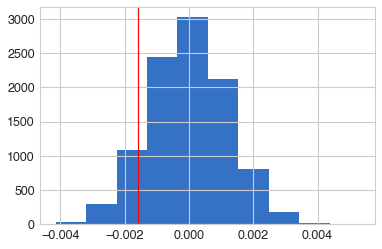

In [230]:
actul_diff = df2[df2.landing_page == 'new_page'].converted.mean() - df2[df2.landing_page == 'old_page'].converted.mean()
# plot histogram of the simulated transactions.
plt.hist(p_diffs);
plt.axvline(x=actul_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [231]:
# actual diff and p_value 
(p_diffs > actul_diff).mean()

0.9028

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**P value**
<p>In part j I calculated the p-value. and it used to determine whether the treatment was effective or not, in this case, the p-value is very large then we can conclude that we fail to reject the null and that there is no evidence to suggest that the new page is better than the old page. </p>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [232]:
import statsmodels.api as sm
# Number of conversion and total numbers for each page.  
convert_old = df.query('landing_page == "old_page"').converted.sum()
convert_new = df.query('landing_page == "new_page"').converted.sum()
n_old = df.query('landing_page == "old_page"').shape[0]
n_new = df.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [233]:
# Using the bult-in function to calculate the z_score and p value 
sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative="smaller")

(1.3683341399998907, 0.9143962454534289)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**
<p>The p value returend from the stats.proportions_ztest function  is big, so the resultes from this question agree with the resultes from parts j and k, which are there are no evidences to suggegst that the new page is batter then the old page. </p>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Regression model**
<p>We should perform logistic regression since we want to predict a categorical variable.</p>

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [234]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [235]:
# Create intercept and dummies columns.
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'], drop_first=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [236]:
#Instantiate the modol and fiting it.
model = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [237]:
# modol summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 06 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        15:08:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Regression p-value**
<p>The p-value for the regression model is 0.190 and it's smaller than the one found in part two because the null is different in the regression model the null is the rate equal to 0 as for part 2 whether the old page rate is greater or equal to the new page rate.</p>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding other factors**
<p>It's a good idea to add other factors to your model because sometimes those factors are relevant in predicting the correct outcome like in this case it's reasonable to assume the country where costumer lives might be relevant and also time might be relevant how much the experience run could impact the conversion rate. The draws back for adding other factors are for example a linear relationship between the response and predicting variables, correlated errors, multicollinearity... </p>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [238]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [239]:
### Create the necessary dummy variables
df_new[['uk', 'us']] = pd.get_dummies(df_new.country, drop_first=True)
model1 = sm.Logit(df_new.converted, df_new[['intercept', 'ab_page','uk', 'us']])
result = model1.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        15:08:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
uk             0.0506      0.028      1.784      0.074      -0.005       0.106
us             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Country impact**
<p>From these results, it appears that the country had an impact on conversion rate since we have a positive coefficient for UK and US which tells us that the conversion rate is larger in the UK and the US compared to Canda, also the p-values are still big which indicate we should not move away from the null and not implement the new page until we get enough evidence that it is better than the old one which we don't in this case.<p>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [240]:
df_new['us_ab_page'] = df_new['us'] * df_new['ab_page']
df_new['uk_ab_page'] = df_new['uk'] * df_new['ab_page']

In [241]:
### Fit Your Linear Model And Obtain the Results
model2 = sm.Logit(df_new.converted, df_new[['intercept', 'ab_page','uk', 'us', 'uk_ab_page', 'us_ab_page']])
result = model2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 06 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:08:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
uk             0.0118      0.040      0.296      0.767      -0.066       0.090
us             0.0175      0.038      0.465      0.642      -0.056       0.091
uk_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
us_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

<a id='conclusions'></a>
## Conclusions

<p>In this project, I analyzed hypothesis testing. In the first part, I found that the conversion rate for the tow pages is almost equal which could be an indication that the new page did not improve the conversion rate which is confirmed by the results from the A/B testing since the p-value calculated was big. The first regression model gave similar results which a big p_value that indicated we should not move away from the null. Finally the second model show there is some difference between countries but still, there is no evidence to suggest the new page is better. So overall the company should not implement the new page and keep the old one until new evidence suggests otherwise, according to the result of this experiment the new page didn't perform better.  </p>

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.